# LangChain Q&A with RAG

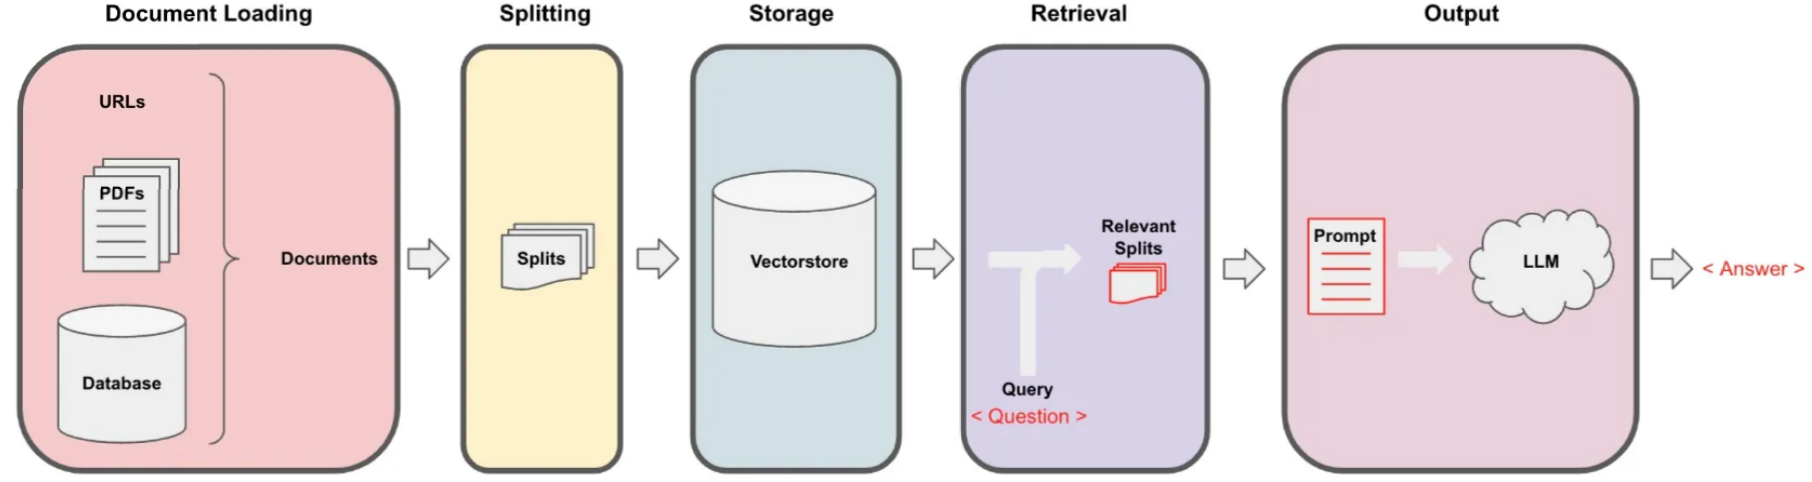
In this section we will be using our vector store retriever in order to create an Agent that uses RAG to answer questions about the documents. We will put together a chain that takes a question, retrieves relevant documents, constructs a prompt that's fed into a LLM, and produces a corresponding answer or output. We will be using Chat Models from LangChain. In this particular case, we will be using ChatOpenAI from langchain as our LLM. You can see more information about the different Chat Models that LangChain offers by clicking [here](https://python.langchain.com/docs/integrations/chat/)

In [1]:
from dotenv import load_dotenv
load_dotenv()
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4", temperature=0)

In [2]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings()
persist_directory = '../utils/vector-store'

vectordb = Chroma(
    embedding_function=embeddings,
    persist_directory=persist_directory
)

In [3]:
retriever = vectordb.as_retriever(
                search_type="similarity",
                search_kwargs={
                    "k": 3,
                },
            )

In [4]:
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_template(
    "{context}\n\nQuestion: {input}"
)

In [5]:
from langchain_classic.chains import create_retrieval_chain
from langchain_classic.chains.combine_documents import create_stuff_documents_chain

qa_chain = create_retrieval_chain(
    retriever,
    create_stuff_documents_chain(llm, prompt)
)

In [6]:
answer = qa_chain.invoke({"input": "Tell me about .net projects"})

In [7]:
print(answer["answer"])

Sure, here are some details about .NET projects:

1. Project Name: Cloud RetailPulse POS
   This project is a Point of Sale (POS) system designed for the retail industry. It is built using C#, .NET Core, Angular, and SQL Server. The system bridges the gap between physical retail and digital data, providing full POS functionality even during internet outages, thanks to its auto-sync feature. The project falls under the category of Desktop & Web Apps and offers services like Business Intelligence and Syncing.

2. Project Name: RetailPulse POS
   Similar to the Cloud RetailPulse POS, this project is also a POS system for the retail industry. It uses the same technologies - C#, .NET Core, Angular, and SQL Server. The system provides full POS functionality during internet outages with auto-sync. It also falls under the category of Desktop & Web Apps and offers services like Business Intelligence and Syncing.

These projects demonstrate the versatility and robustness of .NET in creating comp

## What is Happening? What is RetrievalQA? Enter LangSmith

LangSmith is a unified DevOps platform for developing, collaborating, testing, deploying, and monitoring LLM applications.
You can check more about it [here](https://www.langchain.com/langsmith). To set up a langsmith project, you will need to create an account in langsmith and add the following variables in your .env file.


```
LANGCHAIN_TRACING_V2=true
LANGCHAIN_ENDPOINT="https://api.smith.langchain.com"
LANGCHAIN_API_KEY="<your-api-key>"
LANGCHAIN_PROJECT="ai-assitant-course"
```

# Adding Memory to LangChain Q&A with RAG + LCEL

In this section, we will be improving the Agent, customizing it so that it understands the particular task it has to solve and adding features such as memory to the agent. We will be using LangChain Expression Language, or LCEL. It is a declarative way to easily compose chains together. LCEL was designed from day 1 to support putting prototypes in production, with no code changes, from the simplest “prompt + LLM” chain to the most complex chains. You can check more about LCEL by clicking [here](https://python.langchain.com/docs/expression_language/).

## Rephrase Prompt

This prompt will allow us to capture the chat history of a conversation between the user and the LLM to rephrase or get a standalone question that the new users intent.

In [9]:
from langchain_core.prompts import PromptTemplate

# ------------------------------------------------------
# ------------- Rephrase Prompt ------------------------
# ------------------------------------------------------
template_rephrase = """
Given the following Chat History and a Follow Up Question, rephrase the follow up question to be a standalone question, \
in its original laguage, taking into account all the information in the Chat History. \
If the user says hi, pass through the hi.

Chat History:
{chat_history}

Follow Up Question: {question}
"""
CONDENSE_QUESTION_PROMPT = PromptTemplate.from_template(template_rephrase)

## Final Response Prompt

This prompt provides instructions to the LLM to actually use the context provided to answer the standalone question. It uses few shot prompting to show the model some examples on how to present the answer to the user. These examples are key to display the answers in a correct way. We also provide some context to the LLM so that it knows that it is meant to be a portfolio assistant for burock.

In [10]:
# ------------------------------------------------------
# ------------- Final Response Prompt ------------------
# ------------------------------------------------------


prompt_template = """

### Instruction ###

Act as a portfolio assistant for Burock (a software development company) that answers user query accurately. You
provide answers to user's query on several projects developed by Burock based on
the technology, services, category and industry when they ask for help. You do not hallucinate or make information up.
Answer the question only on the basis of the material provided in the context and also on the basis of the chat history.
If you cannot provide the answer based on the context or the chat history and if it is not related to Burock’s projects,
tell the user "I'm sorry, I cannot assist you with that question" or ask them to contact the sales team if
it is related to budget/cost/services that Burock provides. You don't return answers if asked
about the external world or told to give blog/poem ideas or answer coding questions.

Return only 2–3 projects if asked to return a list of projects.
Don't display that you don't have enough information about any project.

Never infer information or try to make up information to suit the query.

Guidelines to follow

Use the examples as guidelines only and not to answer user queries.

Feel free to ask questions if you don't understand the context of the question.
Never include statements like you don’t have enough information about certain projects in the response.

If you cannot provide an answer based on the context, or if the query is not related to Burock’s projects,
follow the instructions below:

If the question is related to pricing options, budget, cost, or if the user is interested in exploring
new/old projects tailored to their needs, ask the user to contact the sales team. (follow example #3)

For questions unrelated to Burock’s projects or services, respond with:
"I'm sorry, I cannot assist you with that question."

For any query that falls in between (not clearly related or unrelated), use your best judgment to
decide whether to provide an answer or ask the user to contact sales.

Use <a> tags for hyperlinks when providing a link.

### Examples ###

Example #1

Question: Do you have experience in developing machine learning projects?

Answer: Sure, Burock has worked on several machine learning projects.

BabyMaker: This app helps you visualize your future baby with just two photos. The technologies used in this project are C++, Image Analysis, Image Processing Algorithms, Machine Learning, and OpenCV.
Learn more: <a href="https://www.[website].com/portfolio/desktop/babymaker/">BabyMaker</a>

Tachograph Disk Analysis: It is a machine learning app that helps automotive analysts efficiently read tachograph data. The technologies used are C#, C++, Machine Learning, Neural Networks, and Python.
Learn more: <a href="https://www.[website].com/portfolio/desktop/tachograph-disk-analysis/">Tachograph Disk Analysis</a>

Example #2

Question: Write me five letters that start with T.

Answer: I'm sorry, I cannot assist you with that question.

Example #3

Question: Do you offer marketing/sales solutions? | What was the cost of developing the BabyMaker application? |
What is the hourly rate of developing applications?

Answer: As a Portfolio AI agent, I cannot answer this question. Please reach out here:
<a href="https://www.[website].com/contact-us/">Contact Us</a>

Example #4

Question: Have you developed applications using Python?

Answer: Yes, one of the projects is Picflow. It helps all kinds of visual content creators share their content in a more efficient and beautiful way.
The technologies used are Java, JavaScript, Python, Redux, Vue.js, and WebOS.

### Final Action ### 

Take a deep breath and think step by step about which projects provided in the context accurately (not approximately)
answer the question. Verify that the technology, industry, or service mentioned in the question
explicitly exists in the project description.
Only return the project if you are 100% confident; otherwise, follow the fallback rules.

Example (Correct Behavior)

Question: Can you give me examples of projects using A/B testing?

Answer: Sure, Burock has worked on several projects using A/B testing, including:

Recruiting Analytics Dashboard: This project includes A/B testing as one of the services provided.
The dashboard powered by Klipfolio reviews a company's historical hiring process and provides insights on efficiency, retention, and success rates of new hires.
Learn more: <a href="https://www.[website].com/portfolio/financial-modeling-and-analytics/recruiting-analytics-dashboard/">Recruiting Analytics Dashboard</a>

Projects must not be returned if the required technology is not explicitly listed in their description.

Example of exclusion:
Budget Planning Software should not be returned if A/B testing is not mentioned.

### Context ### 

{context}

### Question ###

# {question}
"""


FINAL_ANSWER_PROMPT = PromptTemplate.from_template(prompt_template)

## Chat History Setup

The next lines of code are required for setting up the chat history as an input for the pipeline we are going to be creating. We define a ChatHistory class using Pydantic for data validation and a _format_chat_history function which will allow us to format the chathistory in a way in which the model can read it.

In [12]:
from pydantic import BaseModel, Field
from typing import List, Tuple

class ChatHistory(BaseModel):
    """Chat history with the bot."""

    chat_history: List[Tuple[str, str]] = Field(
        ...,
        json_schema_extra={"widget": {"type": "chat", "input": "question"}},
    )
    question: str


def _format_chat_history(chat_history: List[Tuple]) -> str:
    """Format chat history into a string."""
    buffer = ""
    for dialogue_turn in chat_history:
        human = "Human: " + dialogue_turn[0]
        ai = "Assistant: " + dialogue_turn[1]
        buffer += "\n" + "\n".join([human, ai])
    return buffer


## Retriever Set UP

The next lines of code allow us to set up the retriever as we were previuosly doing, while also adding a _combine_documents function which will allow us to combine the retrieved documents into a string that is then readable by an LLM.

In [16]:
from langchain_core.prompts import format_document
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model = 'text-embedding-ada-002', chunk_size=5000)

persist_directory = '../utils/vector-store'

vectordb = Chroma(
    embedding_function=embeddings,
    persist_directory=persist_directory
)

retriever = vectordb.as_retriever(
                search_type="similarity",
                search_kwargs={
                    "k": 3,
                },
            )

DEFAULT_DOCUMENT_PROMPT = PromptTemplate.from_template(template="{page_content}")

def _combine_documents(
    docs, document_prompt=DEFAULT_DOCUMENT_PROMPT, document_separator="\n\n"
):
    """Combine documents into a single string."""
    doc_strings = [format_document(doc, document_prompt) for doc in docs]
    return document_separator.join(doc_strings)

## Model Pipeline Chain

We will now use LCEL to build our langchain pipeline. To do this, first we need to process the chat history and the new question to create a standalone question that will be used for retrieving the documents and to provide a response to the user. To do this, we use the _format_chat_history, the CONDENSE_QUESTION_PROMPT, pass these through an instance of ChatOpenAI with gpt-4 and retrieve the output in a strig format using StrOutputParser.



In [18]:
from langchain_core.runnables import RunnableMap, RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

_inputs = RunnableMap(
    standalone_question=RunnablePassthrough.assign(
        chat_history=lambda x: _format_chat_history(x["chat_history"])
    )
    | CONDENSE_QUESTION_PROMPT
    | ChatOpenAI(temperature=0, model='gpt-4')
    | StrOutputParser(),
)

We now create a dictionary called context that will allow us to retrieve the relevant documents based on the standalone question and we also need to "pass through" the standalone question through the pipeline for it to be received by the final step of the chain.

In [19]:
from operator import itemgetter

_context = {
    "context": itemgetter("standalone_question") | retriever | _combine_documents,
    "question": lambda x: x["standalone_question"],
}

Finally, we join all the elements of the chain, starting with the inputs which will generate the standalone_question, then going through the context which will allow us to get the relevant documents, we pass that information through our FINAL_ANSWER_PROMPT which we declared above, and use a ChatOpenAI model to actually generate a response. We also use a 
StrOutputParser which allows us to take the output of the LLM and transform it into a string. At last, we generate the chain by adding the input type requested by the chain, this will be useful once we connect the chain with FastAPI.

In [20]:
conversational_qa_chain = (
    _inputs | _context | FINAL_ANSWER_PROMPT | ChatOpenAI(temperature=0, model='gpt-4') | StrOutputParser()
)
chain = conversational_qa_chain.with_types(input_type=ChatHistory)

## Testing the Pipeline

In [21]:
question = 'what react projects do you have?'
answer = chain.invoke({'question': question, 'chat_history':[]})

In [23]:
print(answer)

Sure, Burock has worked on several projects using React.

Cloud PatientFlow EMR: This project streamlines clinical workflows through digitized records. It integrates EHR/EMR systems with high-definition telemedicine suites and AI triage. The technologies used in this project are Java, Spring Boot, React Native, and MySQL.
Learn more: <a href="https://www.[website].com/cloud-patientflow-emr/">Cloud PatientFlow EMR</a>

Pro PatientFlow EMR: This project also streamlines clinical workflows through digitized records. It integrates EHR/EMR systems with high-definition telemedicine suites and AI triage. The technologies used in this project are Java, Spring Boot, React Native, and MySQL.
Learn more: <a href="https://www.[website].com/pro-patientflow-emr/">Pro PatientFlow EMR</a>


## Testing Chat History

In [24]:
chat_history = [[
    question,
    answer
]]

In [25]:
question_2 = 'Tell me more about the first project'
answer_2 = chain.invoke({'question': question_2, 'chat_history':chat_history})

In [26]:
print(answer_2)

Sure, the Cloud PatientFlow EMR is a project developed by Burock in the medical industry. It falls under the category of Healthcare Portals. The project aims to streamline clinical workflows through digitized records. It integrates EHR/EMR systems with high-definition telemedicine suites and AI triage. The technologies used in this project are Java, Spring Boot, React Native, and MySQL. The services provided include HIPAA Compliance and Mobile Development. You can learn more about the project here: <a href="www.[website].com/cloud-patientflow-emr/">Cloud PatientFlow EMR</a>.


## Streaming

In [27]:
for chunk in chain.stream({'question': question, 'chat_history':[]}):
    print(chunk, end="", flush=True)

Sure, Burock has worked on several projects using React.

Cloud PatientFlow EMR: This project streamlines clinical workflows through digitized records. It integrates EHR/EMR systems with high-definition telemedicine suites and AI triage. The technologies used in this project are Java, Spring Boot, React Native, and MySQL.
Learn more: <a href="https://www.[website].com/cloud-patientflow-emr/">Cloud PatientFlow EMR</a>

Pro PatientFlow EMR: This project also streamlines clinical workflows through digitized records. It integrates EHR/EMR systems with high-definition telemedicine suites and AI triage. The technologies used in this project are Java, Spring Boot, React Native, and MySQL.
Learn more: <a href="https://www.[website].com/pro-patientflow-emr/">Pro PatientFlow EMR</a>